# Введение

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Ход работы:

### Шаг 1. Аналитика данных

Загружаем файл с данными и подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

customer_solvency = pd.read_csv('Bank data analysis.csv')

Выведем общую информацию о датафрейме и посмотрим на типы данных столбцов

In [2]:
customer_solvency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Наш датасет состоит из 21 525 записей типы данных для каждого столцба, на первый взгляд, соответствуют содержанию.
Проверим наличие дубликатов и выведем их сумму по всему датафрейму

In [3]:
customer_solvency.duplicated().sum()

54

Обнаружено 54 строки-дубликата, это достаточно много, поэтому необходимо будет их удалить на этапе обработки данных.
Узнаем количество пропусков.

In [4]:
customer_solvency.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Одинаковое количество пропусков в столбцах days_employed и total_income – 2 174. Связь между этими столбцами понятна: невозможно рассчитать общий доход не имея информации о стаже. Не все компании и люди работают по ТК РФ. Так как столбец total_income нам нужен для ответа на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?" , то от этих записей пользы нет. Тем более такая категория клиентов - "Повышенный риск" для банка.

Выведем первые и последние 5 строк датафрейма

In [5]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [6]:
customer_solvency.tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля
21524,2,-1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля


Проведем поверхностный анализ данных по каждому столбцу

Проверим частоту каждого уникального значения в столбце "children"

In [7]:
customer_solvency.sort_values('children')['children'].value_counts().sort_index()

-1        47
 0     14149
 1      4818
 2      2055
 3       330
 4        41
 5         9
 20       76
Name: children, dtype: int64

Наблюдаем что в столбце "Дети" присутствуют отрицательные значения, чего быть не должно, необходимо будет их удалить или разобраться в зависимостях. Также, 76 человек имеет по 20 детей. Выглядит как ошибка в данных, можно предположить, что корретное значение – это 2, а 0 появился при неправильном заполнении данных. Однако, нельзя предполагать в данном случаи, поэтому просто удаляем их.

Проверим значения в столбце "days_employed", а именно просуммируем все его отрицательные значения

In [8]:
customer_solvency[customer_solvency['days_employed'] < 0]['days_employed'].count()

15906

Столбец days_employed имеет тип float64 и содержит отрицательные значения. Всего таких записей 15 906 , т.е. ~73% от общего числа! Будем работать с днями, поэтому приведем тип столбца к int64;

Заметим также, что некоторые значения из столбца слишком большие

In [9]:
customer_solvency[customer_solvency['days_employed'] > 0].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551.952911,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548.489348,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,335581.668515,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью


Положительные значения из датасета выглядят странными. Например, 343937.404131 / 365 дней = 942 лет стажа!
А вот отрицательные значения сделаем абсолютными, т.к. эти данные выглядят правдоподобнее.

Проверим частоту каждого уникального значения в каждом столбце

In [10]:
customer_solvency.sort_values('dob_years')['dob_years'].value_counts().sort_index()

0     101
19     14
20     51
21    111
22    183
23    254
24    264
25    357
26    408
27    493
28    503
29    545
30    540
31    560
32    510
33    581
34    603
35    617
36    555
37    537
38    598
39    573
40    609
41    607
42    597
43    513
44    547
45    497
46    475
47    480
48    538
49    508
50    514
51    448
52    484
53    459
54    479
55    443
56    487
57    460
58    461
59    444
60    377
61    355
62    352
63    269
64    265
65    194
66    183
67    167
68     99
69     85
70     65
71     58
72     33
73      8
74      6
75      1
Name: dob_years, dtype: int64

In [11]:
customer_solvency.sort_values('education')['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

В столбце education встречаются категории в разном регистре – нужно будет привести к единому виду, например, все к прописному виду. И еще раз проверить на дубликаты. Предварительно убедимся в том, что education_id соотносится с нужным типом образования;

In [12]:
customer_solvency['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

В столбце family_status только одна категория Не женат / не замужем выбивается из общей семантики именования – начинается с заглавной буквы;

In [13]:
customer_solvency['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [14]:
customer_solvency['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [15]:
customer_solvency['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Можем наблюдать что большинство значений совпадают по содержанию, но отличаются написанием, необходимо будет категоризировать некоторые данные для корректной аналитики. 

Проверим, есть ли люди с нулевым уровнем дохода.

In [16]:
customer_solvency[customer_solvency['total_income'] == 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


In [17]:
customer_solvency[customer_solvency['total_income'].isnull()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


### Шаг 2. Обработка данных

Приступим к обработке данных на основе наблюдений из шага 1.

Убедимся в том, что income_type соотносится с нужным типом образования.

In [18]:
median_values = pd.pivot_table(
    customer_solvency,
    index=['education', 'income_type'],
    values=['days_employed', 'total_income'],
    aggfunc=np.median
)

median_values

days_employed   total_income
education           income_type                                  
ВЫСШЕЕ              госслужащий       -1424.562274  174909.179988
                    компаньон         -1423.978136  200701.997023
                    пенсионер        367532.282115  165563.164062
                    сотрудник         -1602.753306  144683.271465
Высшее              безработный      395302.838654  202722.511368
                    госслужащий       -3750.610464  161671.347625
                    компаньон         -1453.451901  192451.667511
                    пенсионер        368379.850772  154962.528710
                    сотрудник         -1534.735406  178238.955336
НАЧАЛЬНОЕ           компаньон         -1265.943306  190952.908390
                    пенсионер        360264.985350   90479.336389
                    сотрудник         -1012.313022  212545.366151
НЕОКОНЧЕННОЕ ВЫСШЕЕ компаньон          -775.760267  145528.679914
                    пенсионер        358732.475441  412386.347106
                    сотрудник         -1546.148345  166015.790504
Начальное           госслужащий        -301.333707  190912.178349
                    компаньон         -1030.219648   88227.830722
                    пенсионер        364632.447491   98853.333449
                    сотрудник          -852.697747  129895.001992
Неоконченное высшее госслужащий       -1178.018163  107224.860090
                    компаньон          -711.837088  183379.320368
                    пенсионер        396568.887159   83625.583859
                    сотрудник         -1653.837028  159115.726175
СРЕДНЕЕ             в декрете         -3296.759962   53829.130729
                    госслужащий       -3356.097160  132756.053048
                    компаньон         -1945.914306  157308.365600
                    пенсионер        363541.465259  113656.027279
                    сотрудник         -1567.112656  135823.934197
Среднее             госслужащий       -2291.747052  148529.629601
                    компаньон         -1863.730566  149190.998579
                    пенсионер        363995.316389  128155.229215
                    сотрудник         -1730.667138  133399.107243
УЧЕНАЯ СТЕПЕНЬ      сотрудник          -409.200149  198570.757322
Ученая степень      пенсионер        337584.815560   98752.495442
высшее              госслужащий       -2577.299850  172511.107016
                    компаньон         -1461.167287  201911.716329
                    пенсионер        366157.236636  142825.046222
                    предприниматель    -520.848083  499163.144947
                    сотрудник         -1548.646517  166164.078024
                    студент            -578.751554   98201.625314
начальное           госслужащий       -3043.933615  105766.403301
                    компаньон         -1166.810199  170077.891115
                    пенсионер        358777.901745  104505.757848
                    сотрудник         -1261.719742  124298.759469
неоконченное высшее госслужащий       -2038.132156  165106.669771
                    компаньон         -1032.968329  179867.152890
                    пенсионер        371193.915404  122706.716059
                    сотрудник         -1158.032596  149551.191876
среднее             безработный      337524.466835   59956.991984
                    госслужащий       -2856.781570  136652.970357
                    компаньон         -1645.331963  159652.900458
                    пенсионер        365232.442222  114483.373934
                    сотрудник         -1607.383724  136818.115423
ученая степень      госслужащий       -5968.075884  111392.231107
                    пенсионер        376276.219531  255425.196556
                    сотрудник         -3851.735057  192180.127162

Напишем функцию заполнения пропусков дней стажа на основе сводной таблицы и восстановим пропуски при помощи вычисленных значений.

In [207]:
customer_solvency[customer_solvency['days_employed'] < 0] = customer_solvency[customer_solvency['days_employed'] < 0].astype('int').apply(abs)

Напишем функцию заполнения пропусков уровня дохода на основе сводной таблицы и восстановим пропуски при помощи вычисленных значений

Избавляемся от записей, в которых есть ошибочные данные

In [21]:
customer_solvency = customer_solvency[(customer_solvency['children'] >= 0) & (customer_solvency['children'] <= 5)]
customer_solvency.sort_values('children')['children'].value_counts().sort_index()

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

Проведем замену типа данных по столбцу days_employed

In [22]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Преобразовали количество дней стажа в целочисленный тип при помощи метода `astype`, т.к. `to_numeric` служит для конвертации строк и приводит их к числам с плавающей точкой. Дополнительно столбец избавился от отрицательных значений.

Приведем значения в столбце education к единому регистру и дополнительно удалим дубликаты датасета

In [23]:
customer_solvency['education'] = customer_solvency['education'].str.lower()

In [24]:
customer_solvency.sort_values('education')['education'].value_counts()

среднее                15136
высшее                  5237
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

In [25]:
customer_solvency = customer_solvency.drop_duplicates()
customer_solvency.duplicated().sum()

0

Обработаем столбец purpose. Большинство значений совпадает по содержанию, поэтому создадим отдельный датасет со столбцами: "уникальные значения по столбцу purpose" и "отдельные категории целей получения кредита".

In [26]:
customer_solvency['purpose']

0                       покупка жилья
1             приобретение автомобиля
2                       покупка жилья
3          дополнительное образование
4                     сыграть свадьбу
                     ...             
21520               операции с жильем
21521            сделка с автомобилем
21522                    недвижимость
21523    на покупку своего автомобиля
21524           на покупку автомобиля
Name: purpose, Length: 21348, dtype: object

In [27]:
w = customer_solvency.groupby('purpose').count()[['dob_years']]
#print(c, type(c))
w["purpose_category"] = ['автомобиль', 'автомобиль', 'образование', 'образование', 'жилье', 'образование', 'образование', 
                         'автомобиль', 'автомобиль', 'автомобиль', 'свадьба', 'недвижимость', 'образование', 'жилье', 
                         'недвижимость', 'недвижимость', 'недвижимость', 'недвижимость', 'жилье', 'жилье', 'жилье', 
                         'недвижимость', 'недвижимость', 'жилье', 'образование', 'образование', 'образование', 'автомобиль', 
                         'образование', 'жилье', 'свадьба', 'автомобиль', 'автомобиль', 'автомобиль', 'недвижимость', 
                         'недвижимость', 'недвижимость', 'свадьба']
#print(c)
w = w.drop(columns = 'dob_years')

Наконец, добавим новый столбец с категориями целей кредита

In [28]:
customer_solvency = customer_solvency.merge(w, left_on="purpose", right_on="purpose", how="left")

In [29]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,жилье
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,жилье
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба


Из большого числа вариаций получили всего пять категорий целей кредита – читать и анализировать такие данные намного проще.

### Шаг 3. Категоризируем данные

Для ответа на нижеперечисленные вопросы нам необходимо сегментировать пользователей. Четыре вопроса – четыре раза выполним категоризацию.

> Есть ли зависимость между наличием детей и возвратом кредита в срок?

Распределим клиентов по наличию детей:

* 0 – бездетная
* 1 – однодетная
* 2 – малодетная
* 3+ – многодетная

In [30]:
def categorize_children(count):
    categories = {
        0: 'бездетная',
        1: 'однодетная',
        2: 'малодетная'
    }
    
    return categories.get(count, 'многодетная')

customer_solvency['children_category'] = customer_solvency['children'].apply(categorize_children)
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,children_category
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,жилье,однодетная
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,однодетная
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,жилье,бездетная
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,многодетная
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,бездетная


Следующий вопрос:


> Есть ли зависимость между семейным положением и возвратом кредита в срок?

Всего по семейному положению у нас пять категорий, но давайте сократим запрос и возьмем за основу `family_status_id` до следующих категории:

* "в браке" – женат / замужем, гражданский брак
* "не в браке" – не женат / не замужем, в разводе, вдовец / вдова

In [31]:
def categorize_family_status(value):
    if value == 'женат / замужем':
        return 'в браке'
    
    return 'не в браке'

customer_solvency['family_status_category'] = customer_solvency['family_status'].apply(categorize_family_status)
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,children_category,family_status_category
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,жилье,однодетная,в браке
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,однодетная,в браке
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,жилье,бездетная,в браке
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,многодетная,в браке
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,бездетная,не в браке


Следующий вопрос:


> Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Уровень дохода клиента лучше рассматривать в рамках определенного города или региона, так как уровень жизни и зарплаты могут сильно отличаться. Однако у нас таких данных нет, поэтому работаем с тем что есть.

Посмотрим распределение общего дохода по строкам.

array([[<AxesSubplot:title={'center':'total_income'}>]], dtype=object)

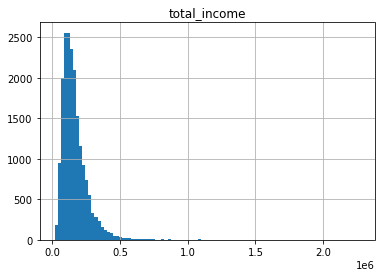

In [32]:
customer_solvency.hist(column='total_income', bins=100)

Поскольку мы восстановили пропуски, то минимальное значение признака `total_income` стало равно `0`. Найдем таже медиану и максимальное значение.

In [33]:
timedian = customer_solvency['total_income'].median()
timedian

145020.80127962783

In [34]:
customer_solvency['total_income'].max()

2265604.028722744

In [35]:
def categorize_total_income(value):
    if value < 50_000:
        return 'низкий'
    elif value <= timedian:
        return 'средний'
    elif value < 350_000:
        return 'выше среднего'
    else:
        return 'высокий'

customer_solvency['total_income_category'] = customer_solvency['total_income'].apply(categorize_total_income)
customer_solvency.tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,children_category,family_status_category,total_income_category
21343,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,жилье,однодетная,не в браке,выше среднего
21344,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,автомобиль,бездетная,в браке,выше среднего
21345,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,недвижимость,однодетная,не в браке,средний
21346,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,автомобиль,многодетная,в браке,выше среднего
21347,2,-1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля,автомобиль,малодетная,в браке,средний


Следующий вопрос:


> Как разные цели кредита влияют на его возврат в срок?

Цели кредита мы уже категоризовали выше на этапе обработки:

* свадьба
* недвижимость
* жилье
* автомобиль
* образование

### Шаг 3. Ответы на вопросы

#### 1. Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [36]:
pd.pivot_table(customer_solvency, index='children_category', values='debt')

,debt
children_category,
бездетная,0.075353
малодетная,0.094542
многодетная,0.081579
однодетная,0.092327


#### Ответ:

* Прямой зависимости между наличием детей и возвратом кредита в срок нет: до `9.4%` клиентов имели задолжности по кредитам, независимо от того были у них дети или нет.
* Бездетные семьи чаще выплачивают кредит. Должники: `~7.5%`.
* Что интересно, многодетные семьи реже остаются в должниках `~8.2%`, чем семьи с одним ребенком `~9.2%` или двумя `~9.4%`.

#### 2. Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [37]:
pd.pivot_table(customer_solvency, index='family_status_category', values='debt')

,debt
family_status_category,
в браке,0.075575
не в браке,0.088637


#### Ответ:

Клиенты, состоящие в браке, на 1.3% реже остаются в должниках.

#### 3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [38]:
pd.pivot_table(customer_solvency, index='total_income_category', values='debt')

,debt
total_income_category,
высокий,0.075911
выше среднего,0.080671
низкий,0.061995
средний,0.084009


* Возврат кредита зависит от уровня дохода клиента: чем выше доход, тем меньше % задолжностей, однако есть исключения
* Люди с низким уровнем дохода имеют самый низкий процент задолжностей по кредитам: `~6.2%`, а вот люди со средним – самый высокий `~8.5%`.
* Самые порядочные заёмщики имеют низкий (должники `~6.2%`) и высокий (должники `~6.4%`) уровень дохода

#### 4. Как разные цели кредита влияют на его возврат в срок?

In [39]:
pd.pivot_table(customer_solvency, index='purpose_category', values='debt')

,debt
purpose_category,
автомобиль,0.093436
жилье,0.069401
недвижимость,0.074731
образование,0.092504
свадьба,0.078744


Посчитав % задолжностей по категориям, можно сделать вывод, что автомобиль `9.3%` и образование `9.2%` не на первом месте в списке приоритетов на выплаты у клиентов, в отличие от жилья `~6.9%`, недвижимости `7.5%` и свадьбы `7.8%`.

#### Итоговая диаграмма

Отобразим процент должников по категориям влияния в виде диаграммы

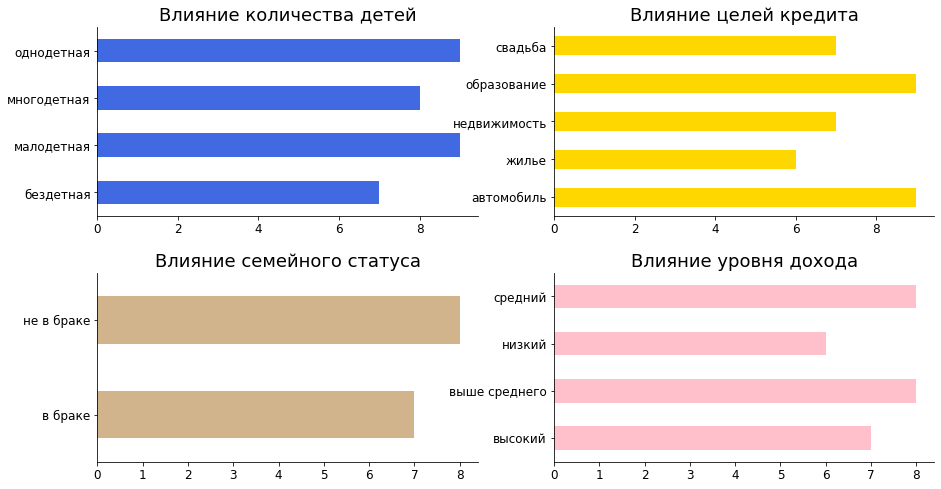

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

child_debt = pd.pivot_table(customer_solvency, index='children_category', values='debt')
family_debt = pd.pivot_table(customer_solvency, index='family_status_category', values='debt')
income_debt = pd.pivot_table(customer_solvency, index='total_income_category', values='debt')
purpose_debt = pd.pivot_table(customer_solvency, index='purpose_category', values='debt')

child_debt.debt = (child_debt.debt * 100).astype(int)
family_debt.debt = (family_debt.debt * 100).astype(int)
income_debt.debt = (income_debt.debt * 100).astype(int)
purpose_debt.debt = (purpose_debt.debt * 100).astype(int)


child_debt['debt'].sort_index().plot.barh(
    ax=axes[0][0], fontsize=12, color='royalblue'
)
axes[0][0].set_title("Влияние количества детей", fontsize=18)
axes[0][0].set_ylabel("")

plt.ylabel("")

family_debt['debt'].sort_index().plot.barh(
    ax=axes[1][0], fontsize=12, color='tan'
)
axes[1][0].set_title("Влияние семейного статуса", fontsize=18)
axes[1][0].set_ylabel("")

plt.ylabel("")

income_debt['debt'].sort_index().plot.barh(
    ax=axes[1][1], fontsize=12, color='pink'
)
axes[1][1].set_title("Влияние уровня дохода", fontsize=18)
axes[1][1].set_ylabel("")


purpose_debt['debt'].sort_index().plot.barh(
    ax=axes[0][1], fontsize=12, color='gold'
)
axes[0][1].set_title("Влияние целей кредита", fontsize=18)
axes[0][1].set_ylabel("")
    
plt.subplots_adjust(hspace=.3)


import seaborn as sns
sns.despine()

### Заключение

В ходе выполнения работы, можно сделать следующую рекомедацию бизнесу по выдаче кредита: безопаснее всего выдавать кредиты на покупку жилья, недвижимости или свадьбу – по ним меньшее количество задолжностей.

Возможно это идеальный портрет клиента:

* Без детей
* В браке
* С низким или высоким уровнем дохода
* Цель кредита – жилье или недвижимость

